In [1]:
import pandas as pd

flight_df = pd.read_csv("flights_historical/train_1.csv")

# reformat departure_time
flight_df['departure_time'] = flight_df['departure_time'].apply(str).apply(lambda x: '0'+x if len(x) != 4 else x)

# reformat the dates
flight_df['month'] = flight_df['month'].apply(lambda x: '0'+x[2:] if len(x) != 4 else x[2:])
flight_df['day_of_month'] = flight_df['day_of_month'].apply(lambda x: '0'+x[2:] if len(x) != 4 else x[2:])
flight_df['day_of_week'] = flight_df['day_of_week'].apply(lambda x: x[2:])
flight_df['is_delayed'] = flight_df['is_delayed'].astype('category').cat.codes

flight_df[['departure_time', 'month', 'day_of_month', 'day_of_week']] = flight_df[['departure_time', 'month', 'day_of_month', 'day_of_week']].apply(pd.to_numeric)

# flight_df

In [2]:
# one-hot encoding/dummy variables for categorical data
dummy_df = flight_df.copy()
dummy_df = pd.get_dummies(dummy_df, columns=['unique_carrier', 'origin', 'destination'], drop_first=True)
dummy_df = dummy_df.rename(columns = {'is_delayed': 'target'})

numeric_cols = ['departure_time', 'month', 'day_of_month', 'day_of_week', 'distance']
category_cols = list(set(dummy_df.columns) - set(numeric_cols) - {'target'})
category_cols.sort()

# dummy_df

In [3]:
# train-test split
from sklearn.model_selection import train_test_split

random_seed = 1147

train_df, test_df = train_test_split(dummy_df,test_size=0.20,random_state=random_seed, stratify=dummy_df['target'])

# train_df

In [4]:
# scaling numeric columns

from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
scaler.fit(train_df[numeric_cols])

def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    X_categorical = df[cat_cols].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = df['target']
    return X, y

X_train, y_train = get_features_and_target_arrays(train_df, numeric_cols, category_cols, scaler)
X_test, y_test = get_features_and_target_arrays(test_df, numeric_cols, category_cols, scaler)

In [5]:
# default decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
y_pred_dt = dtree.predict(X_test)

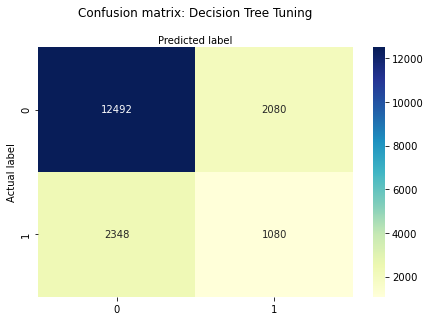

Performance metrics for Decision Tree
Accuracy = 0.75400
Precision = 0.34177
Recall = 0.31505
F1 score = 0.32787



In [6]:
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def get_confusion_heatmap(matrix, title):
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: ' + title, y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(f'graphs/{title}.png')
    
    return plt.show()

def get_performance_metrics(y_test, y_pred, title):
    print('Performance metrics for', title)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    
    print('Accuracy = {:.5f}'.format(acc))
    print('Precision = {:.5f}'.format(precision))
    print('Recall = {:.5f}'.format(recall))
    print('F1 score = {:.5f}'.format(f1score))
    print()
          
    return [acc, precision, recall, f1score]
          
# decision tree
dt_matrix = confusion_matrix(y_test, y_pred_dt)
dt_heatmap = get_confusion_heatmap(dt_matrix, 'Decision Tree Tuning')
dt_perf = get_performance_metrics(y_test, y_pred_dt, 'Decision Tree')

In [7]:
# hyperparameter tuning - maximising f1 score

# DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
#                        min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
#                        max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, 
#                        ccp_alpha=0.0)

# grid search for best hyperparameters
from sklearn.model_selection import GridSearchCV
parameters = {'criterion':['gini','entropy'],'min_samples_split': [5, 10, 20]}
gridsearch = GridSearchCV(DecisionTreeClassifier(), parameters, verbose=1, scoring='f1')
gridsearch.fit(X_train, y_train)

gridsearch.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'criterion': 'entropy', 'min_samples_split': 10}

In [8]:
# best hyperparameters?
fdtree = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 10)
fdtree.fit(X_train,y_train)
y_pred_fdt = fdtree.predict(X_test)

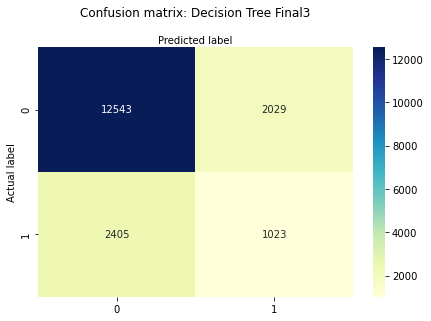

Performance metrics for Final Decision Tree
Accuracy = 0.75367
Precision = 0.33519
Recall = 0.29842
F1 score = 0.31574



In [9]:
# final decision tree?
fdt_matrix = confusion_matrix(y_test, y_pred_fdt)
fdt_heatmap = get_confusion_heatmap(fdt_matrix, 'Decision Tree Final3')
fdt_perf = get_performance_metrics(y_test, y_pred_fdt, 'Final Decision Tree')